In [ ]:
# IMPORTAÇÕES
"""-------------"""
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Modelagem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Carregar os arquivos
orders = pd.read_csv("orders.csv")
missing_items = pd.read_csv("missing_items_data.csv")
drivers = pd.read_csv("drivers_data.csv")
products = pd.read_csv("products_data.csv")
customers = pd.read_csv("customers_data.csv")

# Verificar as primeiras linhas de cada dataset
orders.head(5), missing_items.head(5), drivers.head(5), products.head(5), customers.head(5)


(         date                              order_id order_amount  \
 0  2023-01-01  c9da15aa-be24-4871-92a3-dfa7746fff69    $1,095.54   
 1  2023-01-01  ccacc183-09f8-4fd5-af35-009d18656326      $659.11   
 2  2023-01-01  f4e1d30b-c3d1-413f-99b8-93c0b46d68bf      $251.45   
 3  2023-01-01  993d31f4-9358-41f0-a371-0021e55cef5d      $598.83   
 4  2023-01-01  3e0a8f1b-3cd6-4d64-90e3-6b38dc368925       $27.18   
 
               region  items_delivered  items_missing delivery_hour  driver_id  \
 0        Winter Park               10              1       8:37:28  WDID10627   
 1  Altamonte Springs               11              1       9:31:17  WDID10533   
 2        Winter Park               18              1      10:43:49  WDID10559   
 3  Altamonte Springs               12              1       9:48:33  WDID10622   
 4           Clermont                3              1      10:09:49  WDID10654   
 
   customer_id  
 0    WCID5031  
 1    WCID5794  
 2    WCID5599  
 3    WCID5005  
 4   

In [3]:
# 1. Verifique colunas
print("Colunas do DataFrame:", orders.columns)

# 2. Converta para string, se ainda não for
orders["order_amount"] = orders["order_amount"].astype(str)

# 3. Limpe símbolos estranhos e cifrão
orders["order_amount"] = orders["order_amount"].replace(r"[^\d.,-]", "", regex=True)
orders["order_amount"] = orders["order_amount"].str.replace(",", ".")

# 4. Converta para float e elimine linhas inválidas
orders["order_amount"] = pd.to_numeric(orders["order_amount"], errors="coerce")
orders.dropna(subset=["order_amount"], inplace=True)

# Verificar rapidamente se a conversão deu certo
print("Tipo de 'order_amount':", orders["order_amount"].dtype)
print("Alguns valores de 'order_amount':")
display(orders["order_amount"].head())


# Corrigir nome da coluna em products
products.rename(columns={"produc_id": "product_id"}, inplace=True)

# Unir missing_items (itens não entregues) para um formato longo (melhor para análise)
missing_items_long = missing_items.melt(id_vars=["order_id"], 
                                        value_vars=["product_id_1", "product_id_2", "product_id_3"],
                                        var_name="missing_item_number", value_name="product_id")

# Remover valores nulos da coluna de produtos não entregues
missing_items_long.dropna(subset=["product_id"], inplace=True)

# Fazer merge das tabelas
walmart_join = orders.merge(drivers, on="driver_id", how="left") \
                     .merge(customers, on="customer_id", how="left") \
                     .merge(missing_items_long, on="order_id", how="left") \
                     .merge(products, on="product_id", how="left")

# CARREGAMENTO DO DATASET
"""-------------"""
walmart_join = pd.read_csv("walmart_join.csv")

Colunas do DataFrame: Index(['date', 'order_id', 'order_amount', 'region', 'items_delivered',
       'items_missing', 'delivery_hour', 'driver_id', 'customer_id'],
      dtype='object')
Tipo de 'order_amount': float64
Alguns valores de 'order_amount':


1    659.11
2    251.45
3    598.83
4     27.18
5    494.32
Name: order_amount, dtype: float64

In [4]:
# Estatísticas iniciais sobre fraudes

# Total de pedidos com pelo menos um item não entregue
total_pedidos = walmart_join["order_id"].nunique()
pedidos_com_fraude = walmart_join[walmart_join["items_missing"] > 0]["order_id"].nunique()

# Percentual de pedidos com itens não entregues
percentual_fraude = (pedidos_com_fraude / total_pedidos) * 100

# Motoristas mais envolvidos em pedidos com itens não entregues
fraude_por_motorista = walmart_join[walmart_join["items_missing"] > 0] \
    .groupby(["driver_id", "driver_name"])["order_id"].nunique() \
    .reset_index().sort_values(by="order_id", ascending=False)

# Clientes que mais reportam itens não entregues
fraude_por_cliente = walmart_join[walmart_join["items_missing"] > 0] \
    .groupby(["customer_id", "customer_name"])["order_id"].nunique() \
    .reset_index().sort_values(by="order_id", ascending=False)

# Categorias de produtos mais reportadas como não entregues
fraude_por_categoria = walmart_join[walmart_join["items_missing"] > 0] \
    .groupby("category")["order_id"].nunique() \
    .reset_index().sort_values(by="order_id", ascending=False)

# Exibir estatísticas
stats = {
    "Total de Pedidos": total_pedidos,
    "Pedidos com Itens Não Entregues": pedidos_com_fraude,
    "Percentual de Pedidos com Problema (%)": round(percentual_fraude, 2)
}

print("Estatísticas sobre Fraudes:")
print(stats)

print("\nMotoristas com mais pedidos com itens não entregues:")
display(fraude_por_motorista.head(10))

print("\nClientes que mais reportam itens não entregues:")
display(fraude_por_cliente.head(10))

print("\nCategorias mais reportadas como não entregues:")
display(fraude_por_categoria.head(10))

stats


Estatísticas sobre Fraudes:
{'Total de Pedidos': 10000, 'Pedidos com Itens Não Entregues': 1502, 'Percentual de Pedidos com Problema (%)': 15.02}

Motoristas com mais pedidos com itens não entregues:


,driver_id,driver_name,order_id
0,WDID09873,Pamela Moore,4
143,WDID10463,Rebecca Lin,4
145,WDID10465,Kirk Parker,4
146,WDID10466,Alison Knight,4
147,WDID10467,Amy Fox,4
148,WDID10468,Joan Melton,4
149,WDID10469,Leslie Powell,4
150,WDID10470,Wendy Vincent,4
151,WDID10471,Amanda Malone,4
152,WDID10472,Brent Green,4



Clientes que mais reportam itens não entregues:


,customer_id,customer_name,order_id
496,WCID5685,Shelley Gould,7
592,WCID5820,Edward Henry,7
5,WCID5007,Timothy Daniel,6
248,WCID5339,Jerry Mullen,5
703,WCID5978,Raymond Chavez,5
784,WCID6096,Holly Stewart,5
32,WCID5046,James Hopkins,5
8,WCID5014,David Jackson,5
617,WCID5857,Douglas Roth,5
620,WCID5860,Robert Sanchez,5



Categorias mais reportadas como não entregues:


,category,order_id
1,Supermarket,1232
0,Electronics,269


{'Total de Pedidos': 10000,
 'Pedidos com Itens Não Entregues': 1502,
 'Percentual de Pedidos com Problema (%)': 15.02}

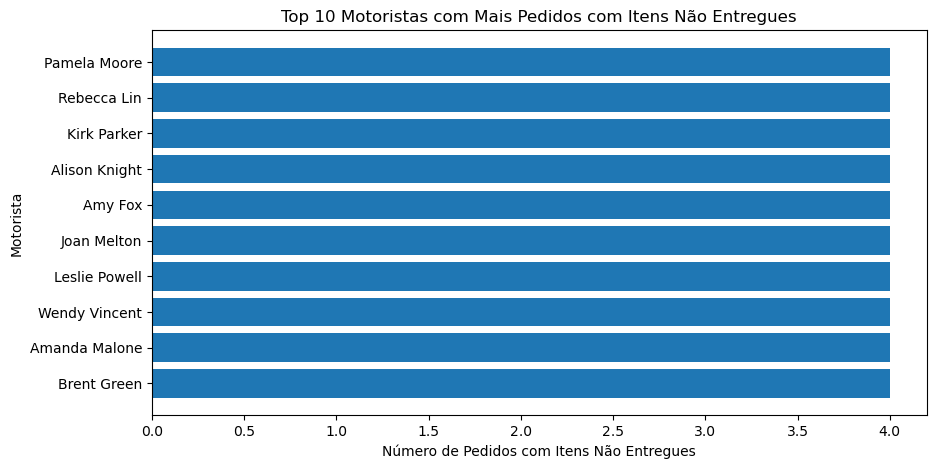

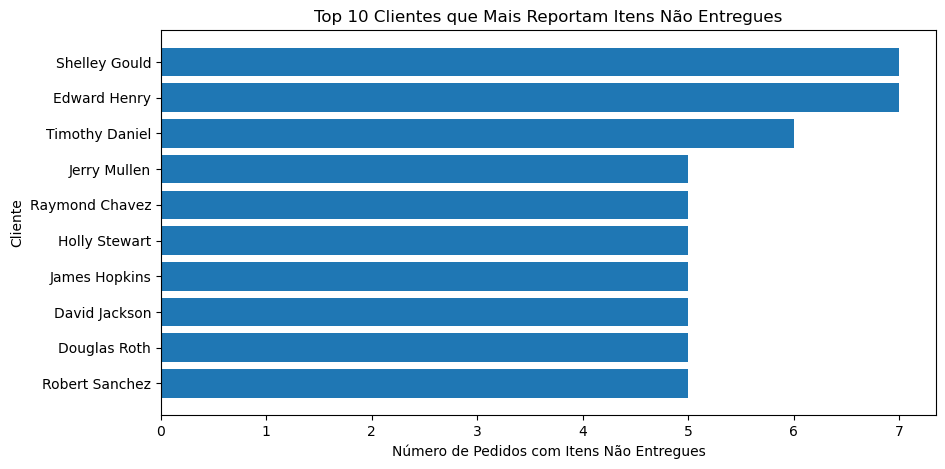

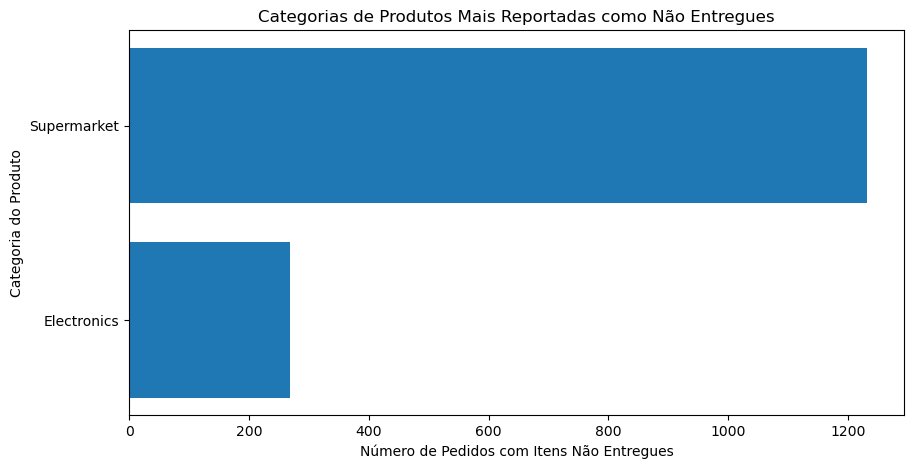

In [5]:
# Gráfico: Motoristas com mais pedidos onde houve itens não entregues
plt.figure(figsize=(10, 5))
plt.barh(fraude_por_motorista["driver_name"].head(10), fraude_por_motorista["order_id"].head(10))
plt.xlabel("Número de Pedidos com Itens Não Entregues")
plt.ylabel("Motorista")
plt.title("Top 10 Motoristas com Mais Pedidos com Itens Não Entregues")
plt.gca().invert_yaxis()  # Inverter eixo para melhor visualização
plt.show()

# Gráfico: Clientes que mais reportam itens não entregues
plt.figure(figsize=(10, 5))
plt.barh(fraude_por_cliente["customer_name"].head(10), fraude_por_cliente["order_id"].head(10))
plt.xlabel("Número de Pedidos com Itens Não Entregues")
plt.ylabel("Cliente")
plt.title("Top 10 Clientes que Mais Reportam Itens Não Entregues")
plt.gca().invert_yaxis()
plt.show()

# Gráfico: Categorias mais reportadas como não entregues
plt.figure(figsize=(10, 5))
plt.barh(fraude_por_categoria["category"].head(10), fraude_por_categoria["order_id"].head(10))
plt.xlabel("Número de Pedidos com Itens Não Entregues")
plt.ylabel("Categoria do Produto")
plt.title("Categorias de Produtos Mais Reportadas como Não Entregues")
plt.gca().invert_yaxis()
plt.show()

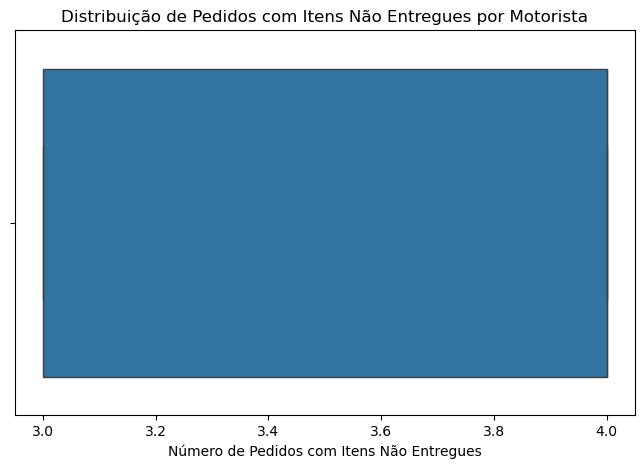

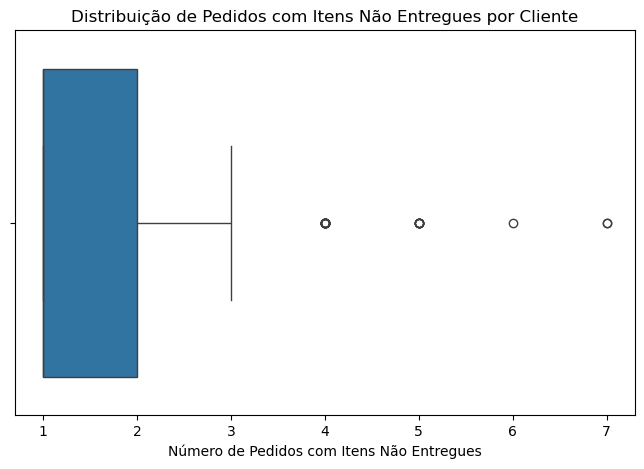

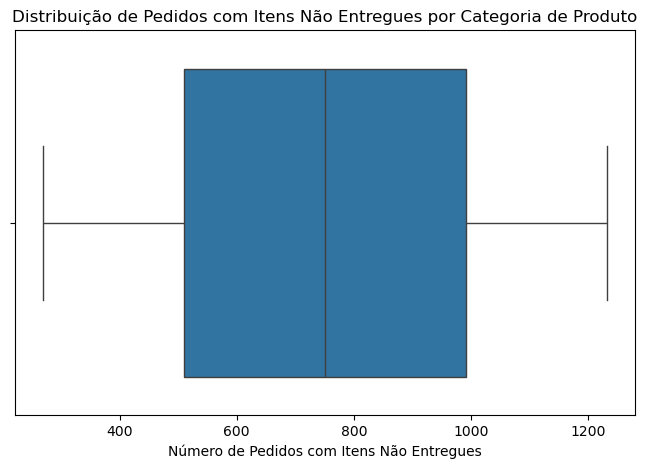

In [6]:
# Análise de outliers nos motoristas (pedidos com itens não entregues)
plt.figure(figsize=(8, 5))
sns.boxplot(x=fraude_por_motorista["order_id"])
plt.title("Distribuição de Pedidos com Itens Não Entregues por Motorista")
plt.xlabel("Número de Pedidos com Itens Não Entregues")
plt.show()

# Análise de outliers nos clientes (pedidos com itens não entregues)
plt.figure(figsize=(8, 5))
sns.boxplot(x=fraude_por_cliente["order_id"])
plt.title("Distribuição de Pedidos com Itens Não Entregues por Cliente")
plt.xlabel("Número de Pedidos com Itens Não Entregues")
plt.show()

# Análise de outliers nas categorias de produtos
plt.figure(figsize=(8, 5))
sns.boxplot(x=fraude_por_categoria["order_id"])
plt.title("Distribuição de Pedidos com Itens Não Entregues por Categoria de Produto")
plt.xlabel("Número de Pedidos com Itens Não Entregues")
plt.show()

In [7]:
# Definição de outliers usando o IQR (Interquartile Range)
def identificar_outliers(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    return df[(df[coluna] > limite_superior)]

# Identificar outliers nos motoristas
outliers_motoristas = identificar_outliers(fraude_por_motorista, "order_id")

# Identificar outliers nos clientes
outliers_clientes = identificar_outliers(fraude_por_cliente, "order_id")

# Identificar outliers nas categorias de produtos
outliers_categorias = identificar_outliers(fraude_por_categoria, "order_id")

# Exibir os resultados
print("Motoristas com padrões suspeitos")
display(outliers_motoristas)

print("\nClientes com padrões suspeitos")
display(outliers_clientes)

print("\nCategorias de produtos com padrões suspeitos")
display(outliers_categorias)


Motoristas com padrões suspeitos


,driver_id,driver_name,order_id



Clientes com padrões suspeitos


,customer_id,customer_name,order_id
496,WCID5685,Shelley Gould,7
592,WCID5820,Edward Henry,7
5,WCID5007,Timothy Daniel,6
248,WCID5339,Jerry Mullen,5
703,WCID5978,Raymond Chavez,5
784,WCID6096,Holly Stewart,5
32,WCID5046,James Hopkins,5
8,WCID5014,David Jackson,5
617,WCID5857,Douglas Roth,5
620,WCID5860,Robert Sanchez,5



Categorias de produtos com padrões suspeitos


,category,order_id


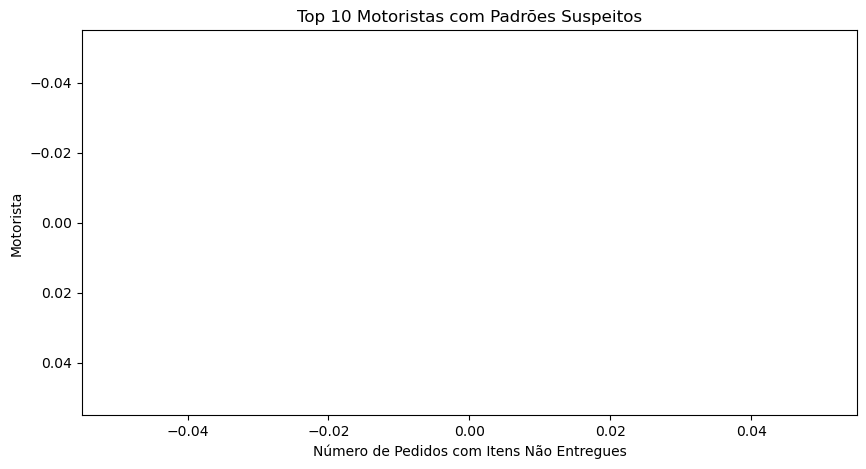

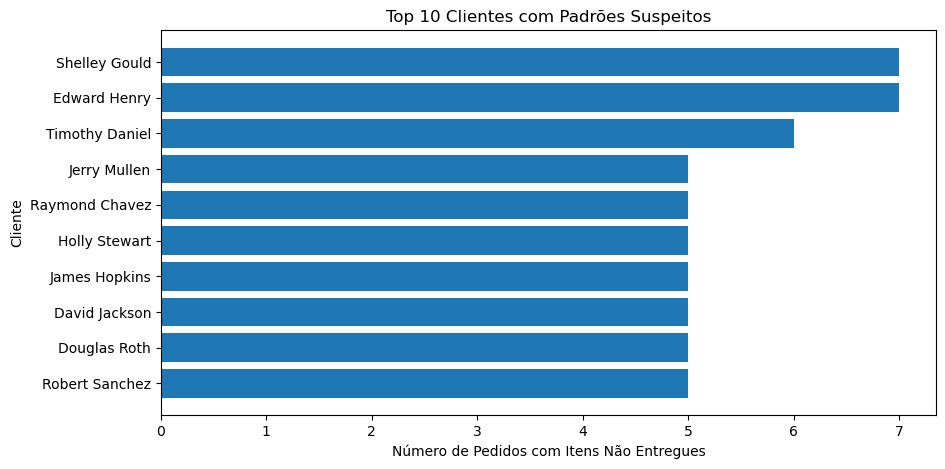

In [8]:
# Gráfico: Motoristas com padrões suspeitos (outliers)
plt.figure(figsize=(10, 5))
plt.barh(outliers_motoristas["driver_name"].head(10), outliers_motoristas["order_id"].head(10))
plt.xlabel("Número de Pedidos com Itens Não Entregues")
plt.ylabel("Motorista")
plt.title("Top 10 Motoristas com Padrões Suspeitos")
plt.gca().invert_yaxis()
plt.show()

# Gráfico: Clientes com padrões suspeitos (outliers)
plt.figure(figsize=(10, 5))
plt.barh(outliers_clientes["customer_name"].head(10), outliers_clientes["order_id"].head(10))
plt.xlabel("Número de Pedidos com Itens Não Entregues")
plt.ylabel("Cliente")
plt.title("Top 10 Clientes com Padrões Suspeitos")
plt.gca().invert_yaxis()
plt.show()


In [9]:
# Analisar qual critério melhor se encaixa nos dados

# Critério 1: Fraude do Entregador - Motoristas com alto percentual de pedidos problemáticos
fraude_motorista = walmart_join.groupby("driver_id").agg(
    total_pedidos=("order_id", "nunique"),
    pedidos_com_problema=("items_missing", lambda x: (x > 0).sum())
)
fraude_motorista["percentual_problema"] = (fraude_motorista["pedidos_com_problema"] / fraude_motorista["total_pedidos"]) * 100

# Critério 2: Erro do Sistema/Processo - Regiões e horários com padrões anômalos
fraude_regiao_hora = walmart_join.groupby(["region", "delivery_hour"]).agg(
    total_pedidos=("order_id", "nunique"),
    pedidos_com_problema=("items_missing", lambda x: (x > 0).sum())
)
fraude_regiao_hora["percentual_problema"] = (fraude_regiao_hora["pedidos_com_problema"] / fraude_regiao_hora["total_pedidos"]) * 100

# Critério 3: Fraude do Consumidor - Clientes com alto percentual de pedidos problemáticos
fraude_cliente = walmart_join.groupby("customer_id").agg(
    total_pedidos=("order_id", "nunique"),
    pedidos_com_problema=("items_missing", lambda x: (x > 0).sum())
)
fraude_cliente["percentual_problema"] = (fraude_cliente["pedidos_com_problema"] / fraude_cliente["total_pedidos"]) * 100

# Exibir os resultados
# Exibir os resultados
print("Análise de Fraude por Motorista")
display(fraude_motorista.sort_values(by="percentual_problema", ascending=False).head(10))

print("\nAnálise de Fraude por Região e Hora")
display(fraude_regiao_hora.sort_values(by="percentual_problema", ascending=False).head(10))

print("\nAnálise de Fraude por Cliente")
display(fraude_cliente.sort_values(by="percentual_problema", ascending=False).head(10))

Análise de Fraude por Motorista


,total_pedidos,pedidos_com_problema,percentual_problema
driver_id,,,
WDID10495,11,4,36.363636
WDID10507,11,4,36.363636
WDID10499,11,4,36.363636
WDID10500,11,4,36.363636
WDID10501,11,4,36.363636
WDID10502,11,4,36.363636
WDID10503,11,4,36.363636
WDID10504,11,4,36.363636
WDID10505,11,4,36.363636



Análise de Fraude por Região e Hora


total_pedidos  pedidos_com_problema  \
region      delivery_hour                                        
Kissimmee   6:28:33                    1                     1   
Clermont    9:13:32                    1                     1   
Apopka      14:28:47                   1                     1   
Winter Park 0:16:29                    1                     1   
Apopka      14:20:14                   1                     1   
            14:19:35                   1                     1   
            14:14:11                   1                     1   
Orlando     22:18:40                   1                     1   
Apopka      14:07:17                   1                     1   
Winter Park 0:20:57                    1                     1   

                           percentual_problema  
region      delivery_hour                       
Kissimmee   6:28:33                      100.0  
Clermont    9:13:32                      100.0  
Apopka      14:28:47                     100.0  
Winter Park 0:16:29                      100.0  
Apopka      14:20:14                     100.0  
            14:19:35                     100.0  
            14:14:11                     100.0  
Orlando     22:18:40                     100.0  
Apopka      14:07:17                     100.0  
Winter Park 0:20:57                      100.0


Análise de Fraude por Cliente


,total_pedidos,pedidos_com_problema,percentual_problema
customer_id,,,
WCID5903,1,1,100.000000
WCID5131,4,3,75.000000
WCID5698,4,3,75.000000
WCID5611,3,2,66.666667
WCID5711,3,2,66.666667
WCID6043,3,2,66.666667
WCID5715,5,3,60.000000
WCID5022,5,3,60.000000
WCID5047,5,3,60.000000


In [10]:
# Criar a variável alvo 'fraude_tipo' com base nos critérios

def classificar_fraude(row):
    # Fraude do Consumidor: Cliente com histórico de alta taxa de pedidos problemáticos
    if row["customer_id"] in fraude_cliente[fraude_cliente["percentual_problema"] > 80].index:
        return "Fraude do Consumidor"

    # Fraude do Entregador: Motorista com alta taxa de pedidos problemáticos
    if row["driver_id"] in fraude_motorista[fraude_motorista["percentual_problema"] > 50].index:
        return "Fraude do Entregador"
    
    # Erro do Sistema/Processo: Região/Horário com alta taxa de pedidos problemáticos
    if (row["region"], row["delivery_hour"]) in fraude_regiao_hora[fraude_regiao_hora["percentual_problema"] > 30].index:
        return "Erro do Sistema/Processo"

    return "Sem Fraude"

# Aplicar a função na base de dados
walmart_join["fraude_tipo"] = walmart_join.apply(classificar_fraude, axis=1)

# Exibir a distribuição da variável alvo
fraude_distribuicao = walmart_join["fraude_tipo"].value_counts(normalize=True) * 100

# Mostrar distribuição da variável alvo
print("Distribuição da Variável Alvo (Fraude Tipo")
display(fraude_distribuicao.sort_values(ascending=False))


Distribuição da Variável Alvo (Fraude Tipo


fraude_tipo
Sem Fraude                  84.73
Erro do Sistema/Processo    15.26
Fraude do Consumidor         0.01
Name: proportion, dtype: float64

In [11]:
walmart_join["order_amount"] = walmart_join["order_amount"].replace(r'[\$,]', '', regex=True).astype(float)

# Se estiver usando a coluna price também:
walmart_join["price"] = walmart_join["price"].replace(r'[\$,]', '', regex=True).astype(float)


In [ ]:


# Selecionar features relevantes
features = [
    "order_amount", "items_delivered", "items_missing", "age", "Trips", "customer_age"
]

# Transformar variáveis categóricas para numéricas
le = LabelEncoder()
walmart_join["region"] = le.fit_transform(walmart_join["region"])
walmart_join["delivery_hour"] = le.fit_transform(walmart_join["delivery_hour"])

# Adicionar features categóricas convertidas
features += ["region", "delivery_hour"]

# Variável alvo
target = "fraude_tipo"

# Transformar variável alvo em numérica
walmart_join[target] = le.fit_transform(walmart_join[target])

# Separar os dados em treino e teste (70% treino, 30% teste)
X = walmart_join[features]
y = walmart_join[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Exibir a distribuição das classes após a divisão
import numpy as np

unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(le.inverse_transform(unique), counts))
tools.display_dataframe_to_user(name="Distribuição das Classes no Conjunto de Treino", dataframe=pd.DataFrame.from_dict(class_distribution, orient='index', columns=["Quantidade"]))


In [12]:
# Selecionar features relevantes
features = [
    "order_amount", "items_delivered", "items_missing", "age", "Trips", "customer_age"
]

# Transformar variáveis categóricas para numéricas
le = LabelEncoder()
walmart_join["region"] = le.fit_transform(walmart_join["region"])
walmart_join["delivery_hour"] = le.fit_transform(walmart_join["delivery_hour"])

# Adicionar features categóricas convertidas
features += ["region", "delivery_hour"]

# Variável alvo
target = "fraude_tipo"

# Transformar variável alvo em numérica
walmart_join[target] = le.fit_transform(walmart_join[target])

# Separar os dados em treino e teste (70% treino, 30% teste)
X = walmart_join[features]
y = walmart_join[target]

counts = y.value_counts()
classes_validas = counts[counts > 1].index
X = X[y.isin(classes_validas)]
y = y[y.isin(classes_validas)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Exibir a distribuição das classes após a divisão

unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(le.inverse_transform(unique), counts))

print("Distribuição das Classes no Conjunto de Treino")
display(pd.DataFrame.from_dict(class_distribution, orient='index', columns=["Quantidade"]))



Distribuição das Classes no Conjunto de Treino


,Quantidade
Erro do Sistema/Processo,1068
Sem Fraude,5931


In [13]:
# Calcular pesos das classes para balanceamento
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
weights_dict = dict(zip(np.unique(y_train), class_weights))

# Criar e treinar o modelo Random Forest com pesos ajustados
rf_model = RandomForestClassifier(n_estimators=100, class_weight=weights_dict, random_state=42)
rf_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = rf_model.predict(X_test)

# Avaliar o modelo
report = classification_report(y_test, y_pred, target_names=le.inverse_transform(np.unique(y_train)), output_dict=True)

# Exibir métricas
print("Relatório de Classificação (Random Forest)")
display(pd.DataFrame(report).transpose())

Relatório de Classificação (Random Forest)


,precision,recall,f1-score,support
Erro do Sistema/Processo,1.000000,0.982533,0.991189,458.000000
Sem Fraude,0.996863,1.000000,0.998429,2542.000000
accuracy,0.997333,0.997333,0.997333,0.997333
macro avg,0.998431,0.991266,0.994809,3000.000000
weighted avg,0.997342,0.997333,0.997324,3000.000000


In [ ]:


# Definir os hiperparâmetros para ajuste
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Criar o modelo Random Forest
rf_tuned = RandomForestClassifier(class_weight=weights_dict, random_state=42, n_jobs=-1)

# Grid Search para encontrar os melhores hiperparâmetros
grid_search = GridSearchCV(rf_tuned, param_grid, cv=3, scoring="f1_weighted", verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_rf_model = grid_search.best_estimator_

# Fazer previsões com o melhor modelo
y_pred_tuned = best_rf_model.predict(X_test)

# Avaliar o modelo ajustado
report_tuned = classification_report(y_test, y_pred_tuned, target_names=le.inverse_transform(np.unique(y_train)), output_dict=True)

# Exibir os resultados
print("Relatório de Classificação (Random Forest Ajustado)")
display(pd.DataFrame(report_tuned).transpose())

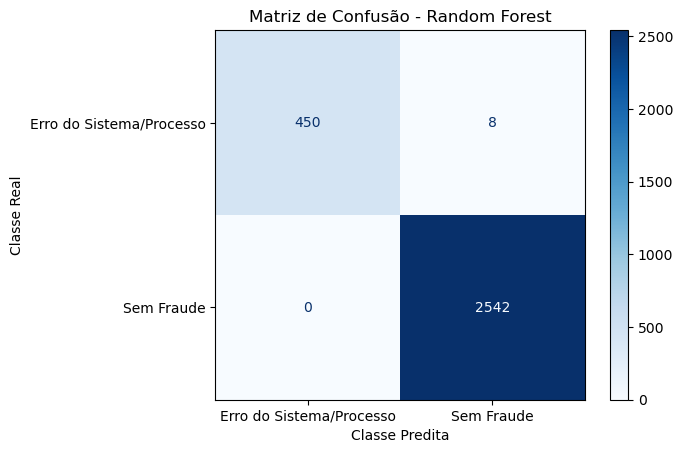

In [14]:
# Gerar a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Exibir a matriz de confusão com rótulos decodificados
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.inverse_transform(np.unique(y_train)))
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.title("Matriz de Confusão - Random Forest")
plt.xlabel("Classe Predita")
plt.ylabel("Classe Real")
plt.show()


In [ ]:
# CARREGAR DADOS PRINCIPAIS

missing_items_data = pd.read_csv("missing_items_data.csv")
products_data = pd.read_csv("products_data.csv")

# Corrigir nome da coluna se necessário
if "produc_id" in products_data.columns:
    products_data.rename(columns={"produc_id": "product_id"}, inplace=True)

# LIMPAR COLUNAS NUMÉRICAS
walmart_join["order_amount"] = walmart_join["order_amount"].replace(r'[\$,]', '', regex=True).astype(float)
products_data["price"] = products_data["price"].replace(r'[\$,]', '', regex=True).astype(float)

# ENCODER PARA O TARGET
le = LabelEncoder()
walmart_join["fraude_tipo"] = le.fit_transform(walmart_join["fraude_tipo"])

# FEATURES E TARGET
features = [
    "order_amount", "items_delivered", "items_missing",
    "age", "Trips", "customer_age", "region", "delivery_hour"
]
X = walmart_join[features]
y = walmart_join["fraude_tipo"]

# REMOVER CLASSES RARAS
counts = y.value_counts()
classes_validas = counts[counts > 1].index
X = X[y.isin(classes_validas)]
y = y[y.isin(classes_validas)]

# TREINO E TESTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# AJUSTE DE PESOS
classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# TREINAR MODELO
rf_model = RandomForestClassifier(n_estimators=100, class_weight=class_weights, random_state=42)
rf_model.fit(X_train, y_train)

# PREDIÇÕES
y_pred = rf_model.predict(X_test)
probs = rf_model.predict_proba(X_test)

# FUNÇÃO PARA GERAR CSV ENRIQUECIDO
def gerar_csv_enriquecido(model, X_test, y_test, y_pred, probs, walmart_join, label_encoder, filename="csv_enriquecido.csv"):
    indices = X_test.index
    base = walmart_join.loc[indices, [
        "order_id", "region", "delivery_hour", "customer_age",
        "driver_id", "items_delivered", "items_missing"
    ]].copy()

    base["classe_real"] = label_encoder.inverse_transform(y_test)
    base["classe_predita"] = label_encoder.inverse_transform(y_pred)
    base["probabilidade_predita"] = probs.max(axis=1)

    for i, class_name in enumerate(label_encoder.inverse_transform(np.unique(y_test))):
        base[f"prob_{class_name}"] = probs[:, i]

    return base

# GERAR CSV ENRIQUECIDO
csv_rico = gerar_csv_enriquecido(
    model=rf_model,
    X_test=X_test,
    y_test=y_test,
    y_pred=y_pred,
    probs=probs,
    walmart_join=walmart_join,
    label_encoder=le,
    filename="dados_para_looker.csv"
)

# INCLUIR PRODUTOS POR PEDIDO
prod_cols = ["product_id_1", "product_id_2", "product_id_3"]
produtos_long = missing_items_data.melt(
    id_vars="order_id",
    value_vars=prod_cols,
    value_name="product_id"
).dropna()

# JUNTAR COM DADOS DOS PRODUTOS
produtos_com_info = produtos_long.merge(products_data, how="left", on="product_id")

# AGRUPAR INFORMAÇÕES POR PEDIDO
produtos_agrupados = produtos_com_info.groupby("order_id").agg({
    "product_name": lambda x: ", ".join(x),
    "category": lambda x: ", ".join(sorted(set(x))),
    "price": lambda x: round(np.sum(x), 2)
}).reset_index()

# JUNTAR COM O CSV FINAL
csv_rico = csv_rico.merge(produtos_agrupados, how="left", on="order_id")

# EXPORTAR CSV FINAL
csv_rico.to_csv("dados_para_looker.csv", index=False)
print("✅ Arquivo final salvo como: dados_para_looker.csv")


✅ Arquivo final salvo como: dados_para_looker.csv
